In [13]:
import tensorflow as tf
import csv
import numpy as np
from PIL import Image
from matplotlib.pyplot import imshow
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession

config = ConfigProto()
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)

from tensorflow.keras.mixed_precision import experimental as mixed_precision
policy = mixed_precision.Policy('mixed_float16')
mixed_precision.set_policy(policy)

INFO:tensorflow:Mixed precision compatibility check (mixed_float16): OK
Your GPU will likely run quickly with dtype policy mixed_float16 as it has compute capability of at least 7.0. Your GPU: GeForce RTX 2070 Super, compute capability 7.5


/home/harvey/tf-env/lib/python3.6/site-packages/tensorflow/python/client/session.py:1751: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


In [14]:
dataset = tf.data.TFRecordDataset(filenames = "records/train00-2071.tfrec")

In [15]:
feature_description = {
    'image': tf.io.FixedLenFeature([], tf.string),
    'image_name': tf.io.FixedLenFeature([], tf.string),
    'target': tf.io.FixedLenFeature([], tf.int64),
}

In [16]:
IMG_SIZE = 512

@tf.function
def toPairs(inp):
    example = tf.io.parse_single_example(inp, feature_description)
    img = tf.io.decode_image(example['image'], expand_animations = False, channels=3)
    img = tf.cast(img, tf.float32)
    img = (img/127.5) - 1
    img = tf.image.resize(img, (IMG_SIZE, IMG_SIZE))
    
    label = example['target']

    return img, label

In [17]:
alldata = dataset.map(toPairs)

In [18]:
total = 0
for i in iter(alldata):
    total += 1
print("{} images in total.".format(total))

2071 images in total.


In [19]:
train = 0.66
val = 0.33

train_data = alldata.take(int(total*train))
leftover = alldata.skip(int(total*train))
val_data = leftover.take(int(total*val))

In [20]:
BATCH_SIZE = 8
train_batches = train_data.batch(BATCH_SIZE)
val_batches = val_data.batch(BATCH_SIZE)

First baseline - Simple ConvNet

In [21]:
img_in = tf.keras.Input(shape=(IMG_SIZE, IMG_SIZE, 3))

conv = tf.keras.layers.Conv2D(64, (3, 3), strides=(1, 1), activation="relu")(img_in)
maxpool = tf.keras.layers.MaxPool2D((3, 3), strides=(1, 1))(conv)
batchnorm = tf.keras.layers.BatchNormalization()(maxpool)
flattened = tf.keras.layers.Flatten()(batchnorm)

predictor = tf.keras.layers.Dense(1, activation="sigmoid")(flattened)

model = tf.keras.Model(inputs=[img_in], outputs=predictor)

Precision - 
How many of the melanoma that we said are bad were actually bad?
Recall -
How many of the bad melanoma did we catch?

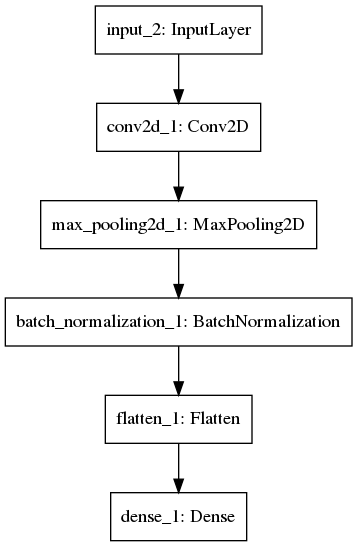

In [22]:
tf.keras.utils.plot_model(model)

In [23]:
model.compile(optimizer=tf.keras.optimizers.Adam(),
          loss=tf.keras.losses.BinaryCrossentropy(from_logits=False),
          metrics=['Precision', 'Recall'])

In [24]:
hist = model.fit(train_batches, validation_data=val_batches, epochs=18)

Epoch 1/18
171/171 [==============================] - 45s 260ms/step - loss: 218.1320 - precision: 0.0388 - recall: 0.1818 - val_loss: 33.0439 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/18
171/171 [==============================] - ETA: 0s - loss: 140.9196 - precision: 0.0000e+00 - recall: 0.0000e+00

KeyboardInterrupt: 